In [1]:
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if you haven't already
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Read and preprocess all books
book_texts = []
book_titles = []

for filename in os.listdir('Data/processed'):
    if filename.endswith('.txt'):
        with open(os.path.join('Data/processed', filename), 'r', encoding='utf-8') as f:
            text = f.read()
            preprocessed_text = preprocess_text(text)
            book_texts.append(preprocessed_text)
            book_titles.append(filename.replace('.txt', ''))

print(f"Processed texts: {book_titles}")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\curti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed texts: ['Assassins_Apprentice_processed', 'A_Song_of_Ice_and_Fire_processed', 'A_Wizard_of_Earthsea', 'Fourth_Wing_processed', 'The_Eye_of_the_World_processed', 'The_Lion_the_Witch_and_the_Wardrobe_processed', 'The_Name_of_the_Wind_processed', 'The_Way_of_Kings_processed']


In [2]:
# Vectorize the texts using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000) # You can adjust the number of features
X = vectorizer.fit_transform(book_texts)

print(f"Shape of the TF-IDF matrix: {X.shape}")


Shape of the TF-IDF matrix: (8, 2000)


In [3]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
num_clusters = 4  # You can adjust this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the predicted cluster labels to the book titles
clusters = kmeans.labels_

# Display the clusters and corresponding book titles
clustered_books = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    clustered_books[label].append(book_titles[idx])

for cluster, books in clustered_books.items():
    print(f"Cluster {cluster}: {', '.join(books)}")


Cluster 0: A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, The_Eye_of_the_World_processed, The_Name_of_the_Wind_processed
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed
Cluster 2: Assassins_Apprentice_processed, Fourth_Wing_processed
Cluster 3: The_Way_of_Kings_processed


In [37]:
from sklearn.cluster import DBSCAN

# Use DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
dbscan_labels = dbscan.fit_predict(X)

# Group books by their DBSCAN cluster labels
dbscan_clusters = {}
for idx, label in enumerate(dbscan_labels):
    if label == -1:
        label = 'Noise'  # -1 indicates noise points in DBSCAN
    if label not in dbscan_clusters:
        dbscan_clusters[label] = []
    dbscan_clusters[label].append(book_titles[idx])

# Display DBSCAN clusters
for label, books in dbscan_clusters.items():
    print(f"Cluster {label}: {', '.join(books)}")


Cluster 0: Assassins_Apprentice_processed, A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, Fourth_Wing_processed, The_Name_of_the_Wind_processed
Cluster Noise: The_Eye_of_the_World_processed, The_Lion_the_Witch_and_the_Wardrobe_processed, The_Way_of_Kings_processed


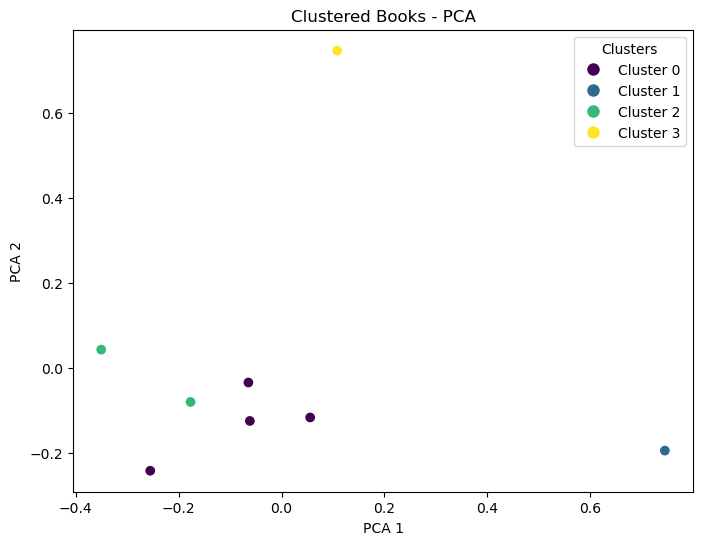

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X.toarray())  # Assuming X is the vectorized document-term matrix

# Plot the clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=kmeans.labels_, cmap='viridis')

# Create a legend with the cluster labels
handles = []
for cluster in np.unique(kmeans.labels_):
    handle = plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {cluster}",
                        markerfacecolor=scatter.cmap(scatter.norm(cluster)), markersize=10)
    handles.append(handle)

# Add the legend to the plot
plt.legend(handles=handles, title="Clusters")

plt.title("Clustered Books - PCA")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



In [6]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.012547575516836511


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

feature_sizes = np.arange(100, 5001, 100)
silhouette_scores = []

for max_feats in feature_sizes:
    # Vectorize with different max_features
    vectorizer = TfidfVectorizer(max_features=max_feats)
    X = vectorizer.fit_transform(book_texts)
    
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X)
    
    # Calculate silhouette score
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Compare silhouette scores for different feature sizes
print(f"Silhouette Scores: {dict(zip(feature_sizes, silhouette_scores))}")


Silhouette Scores: {100: 0.11349535173407489, 200: -0.04864805901184133, 300: -0.04177587117647683, 400: -0.03438346262465209, 500: -0.04034026747552301, 600: 0.027023872145998277, 700: 0.02663239245521936, 800: 0.020081230638669748, 900: 0.019796218393304043, 1000: 0.01081793531520862, 1100: 0.010557440635956731, 1200: 0.010137869117874124, 1300: 0.010139968643454875, 1400: 0.011132964906129616, 1500: 0.011308767428421984, 1600: 0.010969316579671488, 1700: 0.01095593252857317, 1800: 0.01087195947999331, 1900: 0.011045208155980174, 2000: 0.0091688139757858, 2100: 0.009310561386239658, 2200: 0.009584614791393904, 2300: 0.009812082805873144, 2400: 0.010842552844433497, 2500: 0.009844062041815642, 2600: 0.00999056473532433, 2700: 0.009995413525801057, 2800: 0.010107535570833028, 2900: 0.01006778280700287, 3000: 0.010027944382717193, 3100: 0.009999705898458675, 3200: 0.009961689565846706, 3300: 0.009995362730763662, 3400: 0.010015824768654676, 3500: 0.010001810493349868, 3600: 0.0099669987

In [8]:
scores = dict(zip(feature_sizes, silhouette_scores))

In [9]:
scores

{100: 0.11349535173407489,
 200: -0.04864805901184133,
 300: -0.04177587117647683,
 400: -0.03438346262465209,
 500: -0.04034026747552301,
 600: 0.027023872145998277,
 700: 0.02663239245521936,
 800: 0.020081230638669748,
 900: 0.019796218393304043,
 1000: 0.01081793531520862,
 1100: 0.010557440635956731,
 1200: 0.010137869117874124,
 1300: 0.010139968643454875,
 1400: 0.011132964906129616,
 1500: 0.011308767428421984,
 1600: 0.010969316579671488,
 1700: 0.01095593252857317,
 1800: 0.01087195947999331,
 1900: 0.011045208155980174,
 2000: 0.0091688139757858,
 2100: 0.009310561386239658,
 2200: 0.009584614791393904,
 2300: 0.009812082805873144,
 2400: 0.010842552844433497,
 2500: 0.009844062041815642,
 2600: 0.00999056473532433,
 2700: 0.009995413525801057,
 2800: 0.010107535570833028,
 2900: 0.01006778280700287,
 3000: 0.010027944382717193,
 3100: 0.009999705898458675,
 3200: 0.009961689565846706,
 3300: 0.009995362730763662,
 3400: 0.010015824768654676,
 3500: 0.010001810493349868,
 36

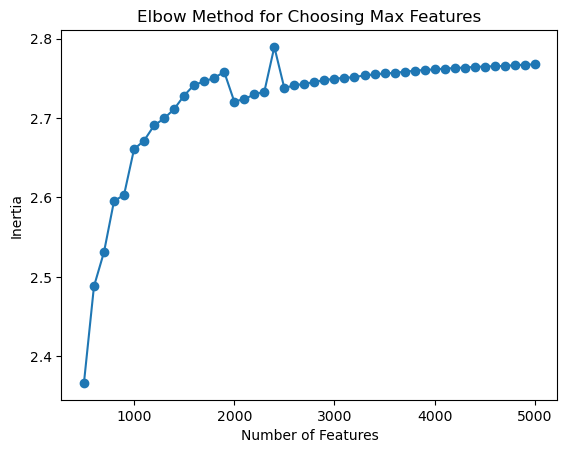

In [10]:
inertias = []
for max_feats in range(500, 5001, 100):  # Try max_features from 100 to 10,000 in steps of 100
    vectorizer = TfidfVectorizer(max_features=max_feats)
    X = vectorizer.fit_transform(book_texts)
    
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X)
    
    inertias.append(kmeans.inertia_)

# Plot inertia values
import matplotlib.pyplot as plt
plt.plot(range(500, 5001, 100), inertias, marker='o')
plt.title('Elbow Method for Choosing Max Features')
plt.xlabel('Number of Features')
plt.ylabel('Inertia')
plt.show()


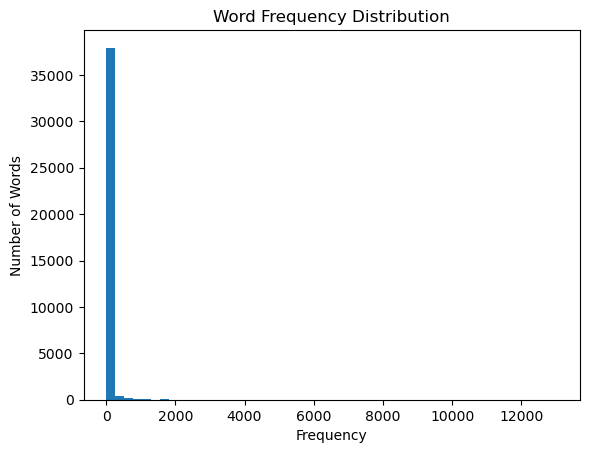

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Count word frequencies across all books
all_words = ' '.join(book_texts).split()
word_freq = Counter(all_words)

# Plot the distribution of word frequencies
word_counts = list(word_freq.values())
plt.hist(word_counts, bins=50)
plt.title('Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.show()


In [13]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
num_clusters = np.arange(2, 9, 1)  # You can adjust this based on your dataset
for j in num_clusters:
    kmeans = KMeans(n_clusters=j, random_state=42)
    kmeans.fit(X)

    # Add the predicted cluster labels to the book titles
    clusters = kmeans.labels_

    # Display the clusters and corresponding book titles
    clustered_books = {i: [] for i in range(j)}
    for idx, label in enumerate(clusters):
        clustered_books[label].append(book_titles[idx])

    for cluster, books in clustered_books.items():
        print(f"Cluster {cluster}: {', '.join(books)}")
    print('\n\n')

Cluster 0: Assassins_Apprentice_processed, A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, Fourth_Wing_processed, The_Eye_of_the_World_processed, The_Name_of_the_Wind_processed, The_Way_of_Kings_processed
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed



Cluster 0: A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, The_Eye_of_the_World_processed, The_Name_of_the_Wind_processed, The_Way_of_Kings_processed
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed
Cluster 2: Assassins_Apprentice_processed, Fourth_Wing_processed



Cluster 0: A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, The_Eye_of_the_World_processed, The_Name_of_the_Wind_processed
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed
Cluster 2: Assassins_Apprentice_processed, Fourth_Wing_processed
Cluster 3: The_Way_of_Kings_processed



Cluster 0: A_Wizard_of_Earthsea
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed
Cluster 2: Assassins_Apprentice_processed
Cluster 3: The_Way_o

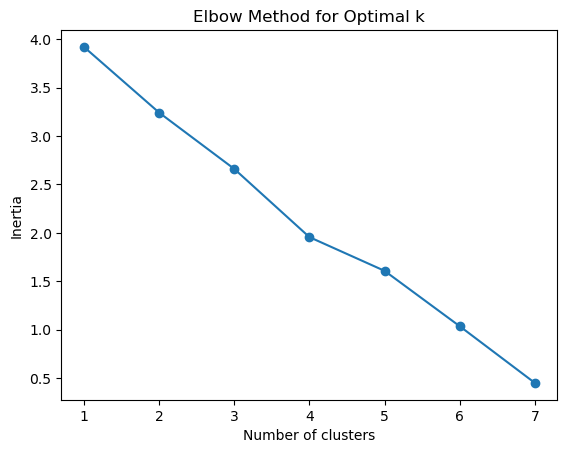

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming you already have your books preprocessed and stored in the list 'books_text'
# Step 1: Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(book_texts)

# Step 2: Apply K-means with different numbers of clusters
inertia = []  # to store the inertia for each k

for k in range(1,8):  # Trying values of k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the inertia values against k
plt.plot(range(1,8), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


In [24]:
# Get the feature names (words)
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
X = vectorizer.fit_transform(book_texts)

# Perform KMeans clustering
num_clusters = 4  # You can adjust this based on your dataset
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add the predicted cluster labels to the book titles
clusters = kmeans.labels_

# Display the clusters and corresponding book titles
clustered_books = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    clustered_books[label].append(book_titles[idx])

for cluster, books in clustered_books.items():
    print(f"Cluster {cluster}: {', '.join(books)}")

Cluster 0: A_Song_of_Ice_and_Fire_processed, A_Wizard_of_Earthsea, The_Eye_of_the_World_processed, The_Name_of_the_Wind_processed
Cluster 1: The_Lion_the_Witch_and_the_Wardrobe_processed
Cluster 2: Assassins_Apprentice_processed, Fourth_Wing_processed
Cluster 3: The_Way_of_Kings_processed


In [25]:
import numpy as np

# Get the cluster centers (centroids) from K-means
cluster_centers = kmeans.cluster_centers_


terms = vectorizer.get_feature_names_out()

# Function to get top n words for each cluster
def get_top_n_words(cluster_centers, terms, n=10):
    top_words = {}
    for i, center in enumerate(cluster_centers):
        # Get the indices of the top n words for the cluster
        top_indices = center.argsort()[-n:][::-1]  # Get indices of the n largest values
        top_words[i] = [terms[index] for index in top_indices]  # Map the indices to words
    return top_words

# Get the top 10 words for each cluster
top_words_per_cluster = get_top_n_words(cluster_centers, terms, n=10)

# Print the top words for each cluster
for cluster, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(top_words)}")



Cluster 0: said, one, rand, would, could, like, back, hand, man, eye
Cluster 1: alice, said, said alice, little, project, gryphon, one, know, work, like
Cluster 2: one, burrich, xaden, verity, would, back, like, know, tairn, chade
Cluster 3: kaladin, dalinar, said, shallan, adolin, one, jasnah, parshendi, sadeas, would


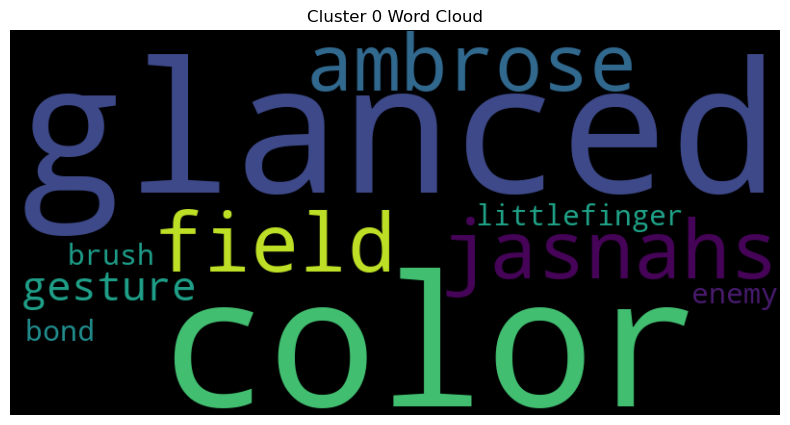

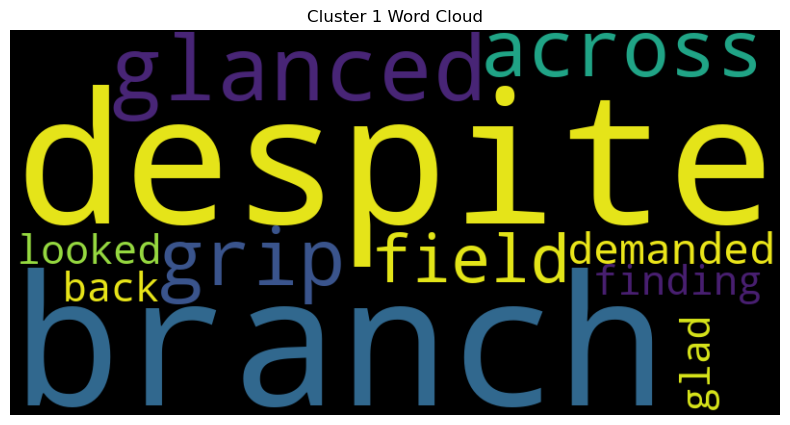

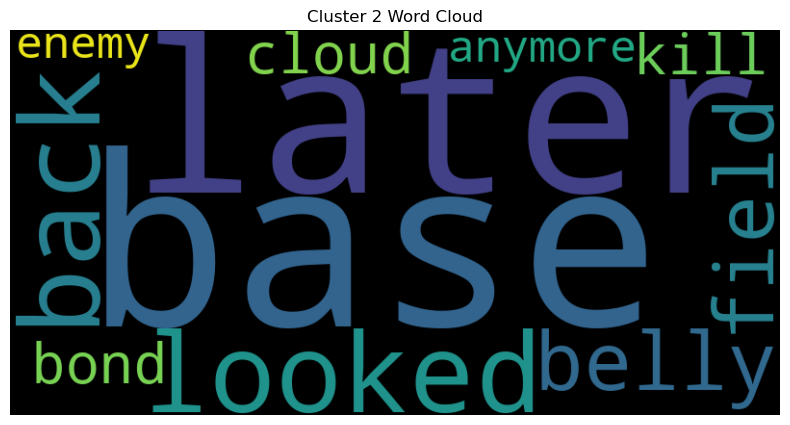

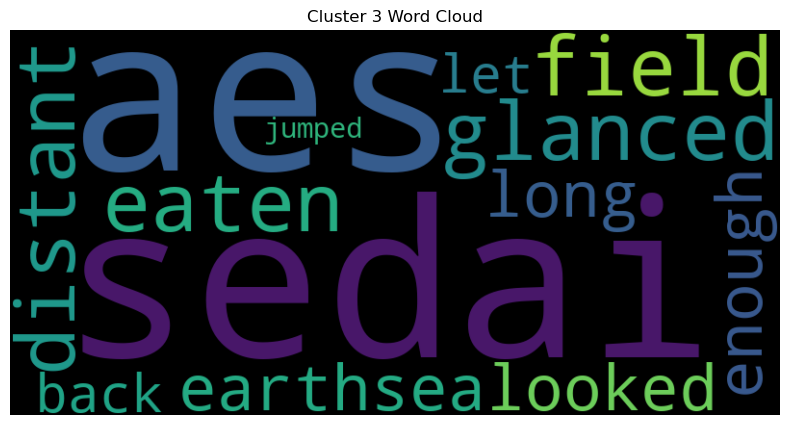

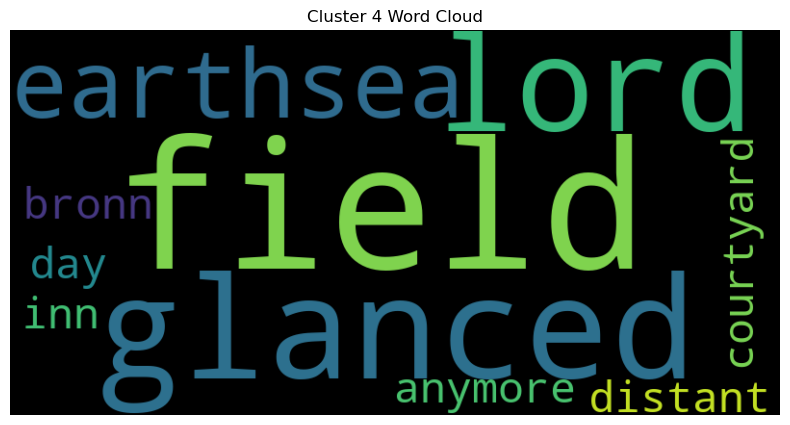

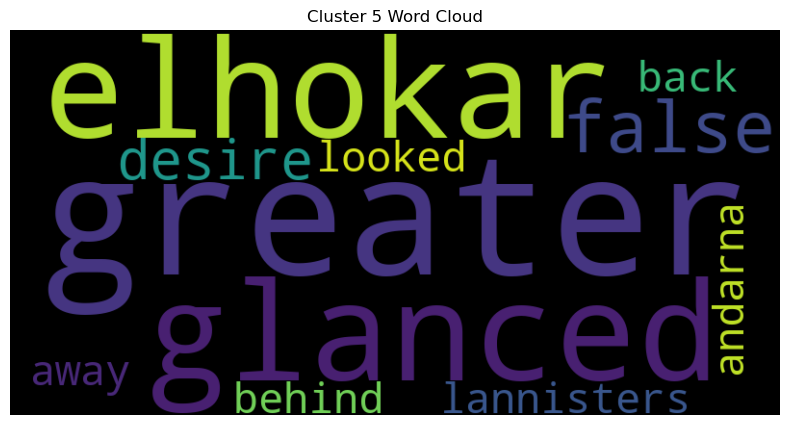

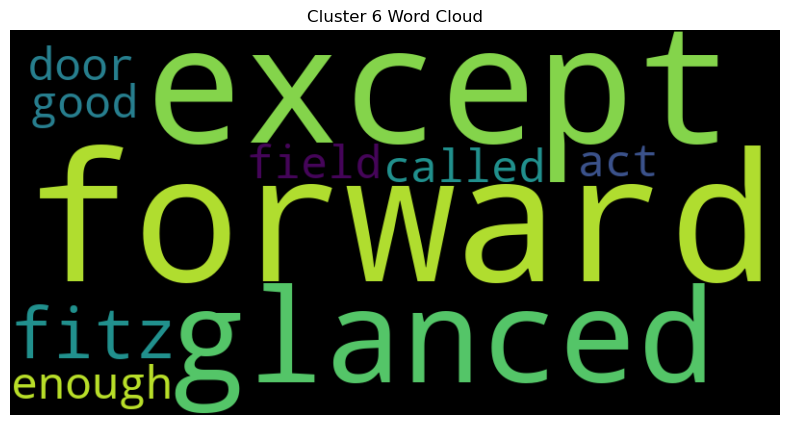

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate and display a word cloud for each cluster
for cluster in top_words_per_cluster:
    # Combine top words into a single string
    words = " ".join(top_words_per_cluster[cluster])
    wordcloud = WordCloud(width=800, height=400).generate(words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Cluster {cluster} Word Cloud")
    plt.show()


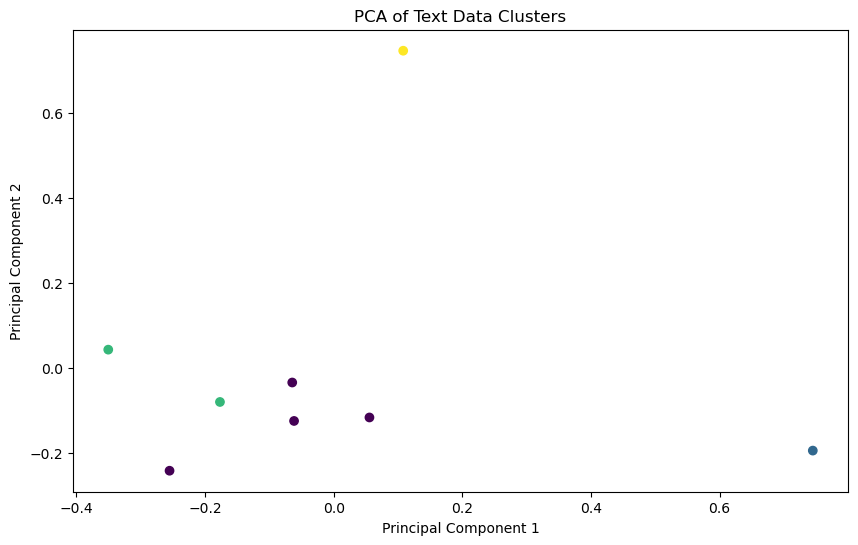

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the number of dimensions to 2 for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())  # X is the term-document matrix

# Plot the data points, colored by their cluster assignment
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.title('PCA of Text Data Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [31]:
from collections import Counter

# Function to get the most frequent words in each cluster
def get_most_frequent_words_per_cluster(X, labels, top_n=10):
    cluster_word_frequencies = {}
    
    for cluster in set(labels):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_words = X[cluster_indices]
        word_counts = cluster_words.sum(axis=0).A1  # Sum word frequencies in the cluster
        top_word_indices = word_counts.argsort()[-top_n:][::-1]  # Get indices of top n words
        top_words = [terms[index] for index in top_word_indices]
        cluster_word_frequencies[cluster] = top_words
    
    return cluster_word_frequencies

cluster_word_frequencies = get_most_frequent_words_per_cluster(X, kmeans.labels_)

# Print out the most frequent words for each cluster
for cluster, words in cluster_word_frequencies.items():
    print(f"Cluster {cluster}: {', '.join(words)}")


Cluster 0: said, one, rand, would, could, like, back, hand, man, eye
Cluster 1: alice, said, said alice, little, project, gryphon, one, know, work, like
Cluster 2: one, burrich, xaden, verity, would, back, like, know, tairn, chade
Cluster 3: kaladin, dalinar, said, shallan, adolin, one, jasnah, parshendi, sadeas, would


In [32]:
from textblob import TextBlob

# Function to compute sentiment polarity for each book
def get_sentiment(texts):
    sentiments = []
    for text in texts:
        blob = TextBlob(text)
        sentiments.append(blob.sentiment.polarity)  # Sentiment polarity: -1 (negative) to 1 (positive)
    return sentiments

# Get sentiment for each book
sentiments = get_sentiment(book_texts)

# Add sentiment information to each cluster for comparison
sentiment_per_cluster = {}
for cluster in set(kmeans.labels_):
    cluster_sentiments = [sentiments[i] for i in range(len(sentiments)) if kmeans.labels_[i] == cluster]
    sentiment_per_cluster[cluster] = np.mean(cluster_sentiments)

# Print out the average sentiment for each cluster
for cluster, avg_sentiment in sentiment_per_cluster.items():
    print(f"Cluster {cluster}: Average sentiment = {avg_sentiment:.2f}")


Cluster 0: Average sentiment = 0.04
Cluster 1: Average sentiment = 0.04
Cluster 2: Average sentiment = 0.05
Cluster 3: Average sentiment = 0.04


In [33]:
import re
import numpy as np
from textstat.textstat import textstat

# Function to extract stylistic features from a book
def extract_stylistic_features(texts):
    features = {
        'avg_sentence_length': [],
        'avg_word_length': [],
        'avg_syllables_per_word': [],
        'readability_score': [],
        'passive_voice_ratio': []
    }
    
    for text in texts:
        sentences = re.split(r'[.!?]', text)
        words = text.split()
        num_sentences = len(sentences)
        num_words = len(words)
        num_syllables = sum(textstat.syllable_count(word) for word in words)
        passive_voice = len(re.findall(r'\b(is|are|was|were|be|been|being)\s+\w+\s+\w+\b', text))  # very basic passive voice check
        
        features['avg_sentence_length'].append(num_words / num_sentences if num_sentences > 0 else 0)
        features['avg_word_length'].append(np.mean([len(word) for word in words]) if num_words > 0 else 0)
        features['avg_syllables_per_word'].append(num_syllables / num_words if num_words > 0 else 0)
        features['readability_score'].append(textstat.flesch_reading_ease(text))
        features['passive_voice_ratio'].append(passive_voice / num_sentences if num_sentences > 0 else 0)
    
    return features

# Assuming `books_text` is a list containing the processed text of each book
stylistic_features = extract_stylistic_features(book_texts)

# Now group the stylistic features by cluster
stylistic_features_per_cluster = {key: {f: [] for f in stylistic_features.keys()} for key in set(kmeans.labels_)}
for cluster in set(kmeans.labels_):
    for i in range(len(stylistic_features['avg_sentence_length'])):
        if kmeans.labels_[i] == cluster:
            for feature in stylistic_features:
                stylistic_features_per_cluster[cluster][feature].append(stylistic_features[feature][i])

# Print the average stylistic features per cluster
for cluster, features in stylistic_features_per_cluster.items():
    print(f"Cluster {cluster}:")
    for feature, values in features.items():
        print(f"  {feature}: {np.mean(values):.2f}")


Cluster 0:
  avg_sentence_length: 161965.00
  avg_word_length: 5.42
  avg_syllables_per_word: 1.44
  readability_score: -164308.20
  passive_voice_ratio: 9.50
Cluster 1:
  avg_sentence_length: 14316.00
  avg_word_length: 5.52
  avg_syllables_per_word: 1.53
  readability_score: -14450.81
  passive_voice_ratio: 0.00
Cluster 2:
  avg_sentence_length: 86105.00
  avg_word_length: 5.50
  avg_syllables_per_word: 1.51
  readability_score: -87316.65
  passive_voice_ratio: 1.00
Cluster 3:
  avg_sentence_length: 205259.00
  avg_word_length: 5.80
  avg_syllables_per_word: 1.55
  readability_score: -208257.96
  passive_voice_ratio: 5.00


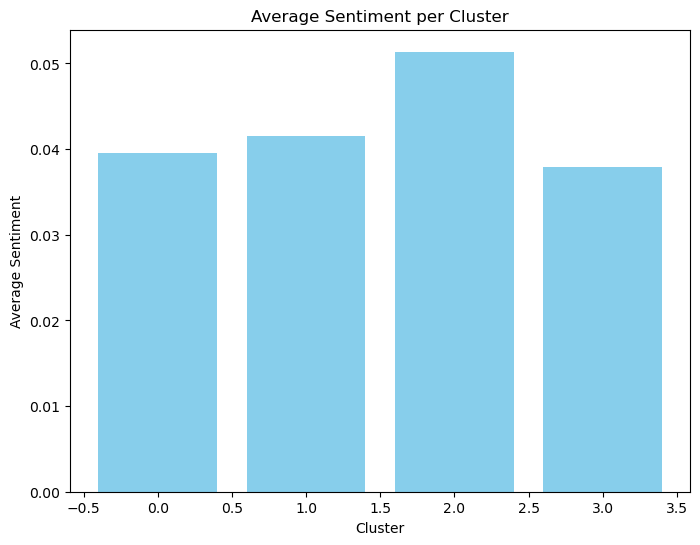

C:\Users\curti\AppData\Local\Temp\ipykernel_83048\2229790865.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([stylistic_features_per_cluster[c]['avg_sentence_length'] for c in stylistic_features_per_cluster], labels=stylistic_features_per_cluster.keys())


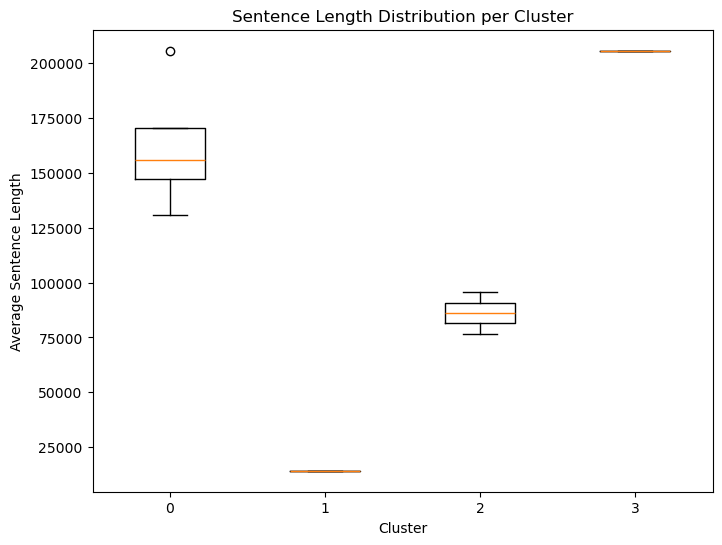

In [40]:
import matplotlib.pyplot as plt

# Example: Bar plot for average sentiment
plt.figure(figsize=(8, 6))
plt.bar(sentiment_per_cluster.keys(), sentiment_per_cluster.values(), color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment per Cluster')
plt.show()

# Example: Box plot for sentence length
plt.figure(figsize=(8, 6))
plt.boxplot([stylistic_features_per_cluster[c]['avg_sentence_length'] for c in stylistic_features_per_cluster], labels=stylistic_features_per_cluster.keys())
plt.xlabel('Cluster')
plt.ylabel('Average Sentence Length')
plt.title('Sentence Length Distribution per Cluster')
plt.show()
